<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/audio_diffusion_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import random
import librosa
import numpy as np
from datasets import load_dataset
from IPython.display import Audio
from librosa.beat import beat_track
from diffusers import DiffusionPipeline

from audiodiffusion import AudioDiffusion

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = torch.Generator(device=device)

### HuggingFace Token Log-in

In [6]:
!huggingface-cli whoami

TimoH


In [7]:
from huggingface_hub import whoami, HfFolder

try:
    user_info = whoami()
    print(f"Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Not logged in. Error: {e}")


Logged in as: TimoH


## DDPM (De-noising Diffusion Probabilistic Models)

### Select model

In [9]:
model_id = "teticio/audio-diffusion-256" # "models/test-model-audio-diffusion-4"  #@param ["teticio/audio-diffusion-256", "teticio/audio-diffusion-breaks-256", "audio-diffusion-instrumenal-hiphop-256", "teticio/audio-diffusion-ddim-256"]

In [10]:
audio_diffusion = AudioDiffusion(model_id).to(device)

unet/diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


AttributeError: 'AudioDiffusion' object has no attribute 'to'

In [8]:
import argparse
import os
import torch
from pathlib import Path
import time
import torchaudio
from torchvision.utils import save_image
from tqdm import tqdm
from diffusers import AudioDiffusionPipeline
from diffusers import (AutoencoderKL, DDIMScheduler, DDPMScheduler,
                       UNet2DConditionModel, UNet2DModel)
from accelerate import Accelerator

accelerator = Accelerator()

In [9]:
model_path = '../models/ssd_512_128/model_step_40000'

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
pipeline = AudioDiffusionPipeline.from_pretrained(model_path).to(device)
mel = pipeline.mel
sample_rate = mel.get_sample_rate()
model = pipeline.unet
vqvae = accelerator.prepare(pipeline.vqvae) if hasattr(pipeline, "vqvae") else None
encodings = accelerator.prepare(pipeline.encodings) if hasattr(pipeline, "encodings") else None

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00, 23.58it/s]


In [71]:
audio_diffusion = DiffusionPipeline.from_pretrained(model_id, safetensors=True).to(device)
mel = audio_diffusion.mel
sample_rate = mel.get_sample_rate()

NameError: name 'model_id' is not defined

In [12]:
def loop_it(audio: np.ndarray,
        sample_rate: int,
        loops: int = 12) -> np.ndarray:
    """Loop audio

    Args:
        audio (np.ndarray): audio as numpy array
        sample_rate (int): sample rate of audio
        loops (int): number of times to loop

    Returns:
        (float, np.ndarray): sample rate and raw audio or None
    """
    _, beats = beat_track(y=audio, sr=sample_rate, units='samples')
    for beats_in_bar in [16, 12, 8, 4]:
        if len(beats) > beats_in_bar:
            return np.tile(audio[beats[0]:beats[beats_in_bar]], loops)
    return None

### Run model inference to generate mel spectrogram, audios and loops

Seed = 1825033948864393


  0%|          | 0/4 [00:00<?, ?it/s]

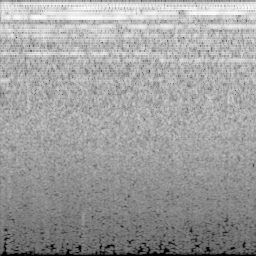

Unable to determine loop points for item 0


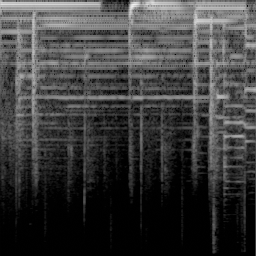

 50%|█████     | 2/4 [00:00<00:00, 11.56it/s]

Unable to determine loop points for item 1


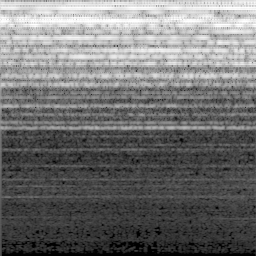

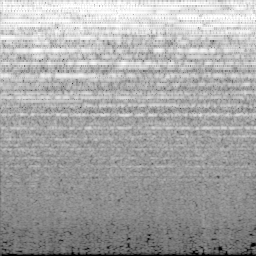

100%|██████████| 4/4 [00:00<00:00,  8.94it/s]


In [35]:
from tqdm import tqdm

for _ in range(1):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    output = pipeline(
        generator=generator,
        batch_size=4,
        return_dict=True,
        steps=100,
        eta=0
    )
    
    # Loop through each generated image and audio in the batch
    for i in tqdm(range(len(output.images))):
        image = output.images[i]
        audio = output.audios[i, 0]
        display(image)
        display(Audio(audio, rate=sample_rate))
        loop = loop_it(audio, sample_rate)
        if loop is not None:
            display(Audio(loop, rate=sample_rate))
        else:
            print(f"Unable to determine loop points for item {i}")


### Generate variations of audios

Try playing around with `start_steps`. Values closer to zero will produce new samples, while values closer to 1,000 will produce samples more faithful to the original.

In [11]:
import wave
from pydub import AudioSegment

def truncate_wav(input_wav_path, output_wav_path, num_samples):
    audio = AudioSegment.from_wav(input_wav_path)
    frame_rate = audio.frame_rate
    duration_ms = (num_samples / frame_rate) * 1000
    truncated_audio = audio[:duration_ms]
    truncated_audio.export(output_wav_path, format="wav")

In [12]:
num_samples = 90000 
for path in ['hip_hop_beat', 'rnb_beat', 'piano_beat', 'garage_beat', 'reggaeton_beat', 'c_chord_beat']:
    base_path = f"../testing/{path}.wav"
    output_path = f"../testing/{path}_trunc_smaller.wav"
    truncate_wav(base_path, output_path, num_samples)


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


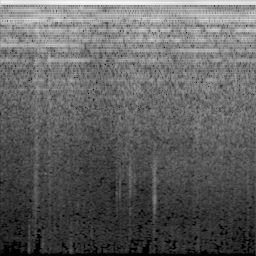

In [55]:
seed = 2391504374279719  #@param {type:"integer"}
generator.manual_seed(seed)
output = pipeline(
    generator=generator,
    batch_size=16,
    steps=100
    )
image = output.images[0]
audio = output.audios[0, 0]
display(image)
display(Audio(audio, rate=sample_rate))

In [26]:
file_path = f"../testing/reggaeton_beat_trunc.wav"

# Load the .wav file
raw_audio, sample_rate = torchaudio.load(file_path)
raw_audio = raw_audio.mean(dim=0, keepdim=True).numpy().squeeze()

In [27]:
display(Audio(raw_audio, rate=sample_rate))

Now using hip_hop_beat as raw audio!


100%|██████████| 1000/1000 [01:06<00:00, 14.94it/s]


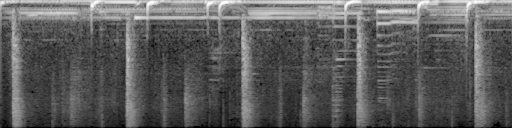

Now using rnb_beat as raw audio!


100%|██████████| 1000/1000 [01:06<00:00, 14.95it/s]


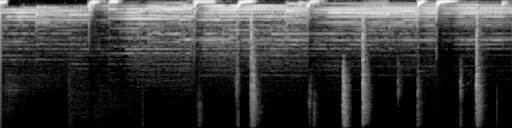

In [14]:
start_steps = [0] # [0, 250, 500, 750, 950] #@param {type:"slider", min:0, max:1000, step:10}
# file_paths = ['hip_hop_beat', 'rnb_beat', 'piano_beat', 'garage_beat', 'reggaeton_beat', 'c_chord_beat']
file_paths = ['hip_hop_beat', 'rnb_beat']

# track = loop_it(audio, sample_rate, loops=1)
for file_path in file_paths:
    print(f'Now using {file_path} as raw audio!')
    for start_step in start_steps:

        output_path = f"../testing/{file_path}_trunc.wav"
        raw_audio, sample_rate = torchaudio.load(output_path)
        raw_audio = raw_audio.mean(dim=0, keepdim=True).numpy().squeeze()
        
        output = pipeline(raw_audio=raw_audio, start_step=start_step)
        image2 = output.images[0]
        audio2 = output.audios[0, 0]
        display(image2)
        display(Audio(audio2, rate=sample_rate))
        
        save_path = f"../testing/audio_variation/{file_path}_{start_step}.wav"
        torchaudio.save(save_path, torch.tensor(audio2).unsqueeze(0), sample_rate)
        # track = np.concatenate([track, loop_it(audio2, sample_rate, loops=1)])
# display(Audio(track, rate=sample_rate))

In [17]:
type(image2)

PIL.Image.Image

### Generate continuations ("out-painting")

100%|██████████| 1000/1000 [01:07<00:00, 14.88it/s]


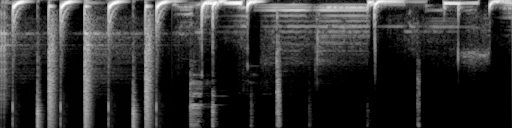

100%|██████████| 1000/1000 [01:06<00:00, 14.97it/s]


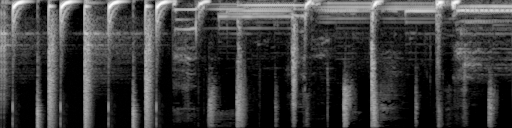

 68%|██████▊   | 684/1000 [00:45<00:21, 14.94it/s]


KeyboardInterrupt: 

In [16]:
overlap_secs = 2  #@param {type:"integer"}
start_step = 0  #@param {type:"slider", min:0, max:1000, step:10}
overlap_samples = overlap_secs * sample_rate
track = raw_audio
for variation in range(12):
    output = pipeline(raw_audio=raw_audio[-overlap_samples:],
                             start_step=start_step,
                             mask_start_secs=overlap_secs)
    image2 = output.images[0]
    audio2 = output.audios[0, 0]
    display(image2)
    display(Audio(audio2, rate=sample_rate))
    track = np.concatenate([track, audio2[overlap_samples:]])
    audio = audio2
display(Audio(track, rate=sample_rate))

### Remix (style transfer)

Alternatively, you can start from another audio altogether, resulting in a kind of style transfer. Maintaining the same seed during generation fixes the style, while masking helps stitch consecutive segments together more smoothly.

In [21]:
try:
    # are we running on Google Colab?
    from google.colab import files
    audio_file = list(files.upload().keys())[0]
except:
    audio_file = "../for_paper/hip_hop_beat_trunc.wav"

In [22]:
start_step = 500  #@param {type:"slider", min:0, max:1000, step:10}
overlap_secs = 2  #@param {type:"integer"}
track_audio, _ = librosa.load(audio_file, mono=True, sr=sample_rate)
overlap_samples = overlap_secs * sample_rate
slice_size = mel.x_res * mel.hop_length
stride = slice_size - overlap_samples

In [23]:
display(Audio(track_audio, rate=sample_rate))

In [53]:
generator = torch.Generator(device=device)
seed = generator.seed()
print(f'Seed = {seed}')
track = np.array([])
not_first = 0
for sample in range(len(track_audio) // stride):
    generator.manual_seed(seed)
    audio = np.array(track_audio[sample * stride:sample * stride + slice_size])
    if not_first:
        # Normalize and re-insert generated audio
        audio[:overlap_samples] = audio2[-overlap_samples:] * np.max(
            audio[:overlap_samples]) / np.max(audio2[-overlap_samples:])
    output = pipeline(raw_audio=audio,
                             start_step=start_step,
                             generator=generator,
                             mask_start_secs=overlap_secs * not_first)
    audio2 = output.audios[0, 0]
    track = np.concatenate([track, audio2[overlap_samples * not_first:]])
    not_first = 1
    display(Audio(track, rate=sample_rate))

Seed = 946639540795532


100%|██████████| 500/500 [00:33<00:00, 14.93it/s]


### Fill the gap ("in-painting")

In [26]:
import numpy as np

def modify_audio(audio, n, mode='noise'):
    if n * 2 > len(audio):
        raise ValueError("The value of n is too large. It must be less than half the length of the audio array.")

    if mode not in ['mask', 'noise']:
        raise ValueError("Invalid mode. Choose 'mask' or 'noise'.")
    
    modified_audio = np.copy(audio)

    middle_length = len(audio) - 2 * n
    if mode == 'noise':
        middle_part = np.random.normal(0, 1, middle_length)
    elif mode == 'mask':
        middle_part = np.zeros(middle_length)

    modified_audio[n:n + middle_length] = middle_part

    return modified_audio


In [28]:
audio_masked = modify_audio(track_audio, 33075, 'mask')
audio_noised = modify_audio(track_audio, 33075, 'noise')

In [29]:
display(Audio(audio_masked, rate=22050))
display(Audio(audio_noised, rate=22050))

In [33]:
seed_value = 42 
generator = torch.Generator(device=device).manual_seed(seed_value)

sample = 1  #@param {type:"integer"}
output = pipeline(raw_audio=audio_noised,
                         mask_start_secs=1.5,
                         mask_end_secs=1.5,
                         start_step=0,
                         step_generator=generator)
audio2 = output.audios[0, 0]
display(Audio(track_audio, rate=sample_rate))
display(Audio(audio2, rate=sample_rate))

100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]


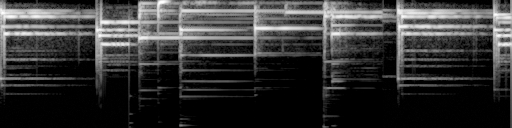

In [120]:
output.images[0]

In [106]:
type(audio2)

numpy.ndarray

## DDIM (De-noising Diffusion Implicit Models)

In [ ]:
audio_diffusion = DiffusionPipeline.from_pretrained('teticio/audio-diffusion-ddim-256').to(device)
mel = audio_diffusion.mel
sample_rate = mel.get_sample_rate()

### Generation can be done in many fewer steps with DDIMs

In [ ]:
for _ in range(10):
    seed = generator.seed()
    print(f'Seed = {seed}')
    generator.manual_seed(seed)
    output = audio_diffusion(generator=generator)
    image = output.images[0]
    audio = output.audios[0, 0]
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")

The parameter eta controls the variance:
* 0 - DDIM (deterministic)
* 1 - DDPM (De-noising Diffusion Probabilistic Model)

In [ ]:
output = audio_diffusion(steps=1000, generator=generator, eta=1)
image = output.images[0]
audio = output.audios[0, 0]
display(image)
display(Audio(audio, rate=sample_rate))

### DDIMs can be used as encoders...

In [ ]:
# Doesn't have to be an audio from the train dataset, this is just for convenience
ds = load_dataset('teticio/audio-diffusion-256')

In [ ]:
image = ds['train'][264]['image']
display(Audio(mel.image_to_audio(image), rate=sample_rate))

In [ ]:
noise = audio_diffusion.encode([image])

In [ ]:
# Reconstruct original audio from noise
output = audio_diffusion(noise=noise, generator=generator)
image = output.images[0]
audio = output.audios[0, 0]
display(Audio(audio, rate=sample_rate))

### ...or to interpolate between audios

In [ ]:
image2 = ds['train'][15978]['image']
display(Audio(mel.image_to_audio(image2), rate=sample_rate))

In [ ]:
noise2 = audio_diffusion.encode([image2])

In [ ]:
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
output = audio_diffusion(
    noise=audio_diffusion.slerp(noise, noise2, alpha),
    generator=generator)
audio = output.audios[0, 0]
display(Audio(mel.image_to_audio(image), rate=sample_rate))
display(Audio(mel.image_to_audio(image2), rate=sample_rate))
display(Audio(audio, rate=sample_rate))

## Latent Audio Diffusion
Instead of de-noising images directly in the pixel space, we can work in the latent space of a pre-trained VAE (Variational AutoEncoder). This is much faster to train and run inference on, although the quality suffers as there are now three stages involved in encoding / decoding: mel spectrogram, VAE and de-noising.

In [ ]:
model_id = "teticio/latent-audio-diffusion-ddim-256"  #@param ["teticio/latent-audio-diffusion-256", "teticio/latent-audio-diffusion-ddim-256"]

In [ ]:
audio_diffusion = DiffusionPipeline.from_pretrained(model_id).to(device)
mel = audio_diffusion.mel
sample_rate = mel.get_sample_rate()

In [ ]:
seed = 3412253600050855  #@param {type:"integer"}
generator.manual_seed(seed)
output = audio_diffusion(generator=generator)
image = output.images[0]
audio = output.audios[0, 0]
display(image)
display(Audio(audio, rate=sample_rate))

In [ ]:
seed2 = 7016114633369557  #@param {type:"integer"}
generator.manual_seed(seed2)
output = audio_diffusion(generator=generator)
image2 = output.images[0]
audio2 = output.audios[0, 0]
display(image2)
display(Audio(audio2, rate=sample_rate))

### Interpolation in latent space
As the VAE forces a more compact, lower dimensional representation for the spectrograms, interpolation in latent space can lead to meaningful combinations of audios. In combination with the (deterministic) DDIM from the previous section, the model can be used as an encoder / decoder to a lower dimensional space.

In [ ]:
generator.manual_seed(seed)
latents = torch.randn(
    (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0],
     audio_diffusion.unet.sample_size[1]),
    generator=generator, device=device)
latents.shape

In [ ]:
generator.manual_seed(seed2)
latents2 = torch.randn(
    (1, audio_diffusion.unet.in_channels, audio_diffusion.unet.sample_size[0],
     audio_diffusion.unet.sample_size[1]),
    generator=generator,
    device=device)
latents2.shape

In [ ]:
alpha = 0.5  #@param {type:"slider", min:0, max:1, step:0.1}
output = audio_diffusion(
    noise=audio_diffusion.slerp(latents, latents2, alpha),
    generator=generator)
audio3 = output.audios[0, 0]
display(Audio(audio, rate=mel.get_sample_rate()))
display(Audio(audio2, rate=mel.get_sample_rate()))
display(Audio(audio3, rate=sample_rate))